## FDW Crop Production Data Analysis - Burkina Faso

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [16]:
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']
df['year'] = df['harvest_year']
df[
    (df['admin_2'] == 'Bale') &
    (df['season_name'] == 'Main') &
    (df['product'] == 'Maize')
].pivot_table(index=['fnid','year'], columns='indicator', values='value')

indicator                  area    production     yield
fnid         year                                      
BF2001A20101 1984   1454.871963    941.297019  0.646996
             1985    277.608078    283.263057  1.020370
             1986   2596.149616   3193.006983  1.229901
             1987   1492.400462   2659.382567  1.781950
             1988   3288.113454   5784.015708  1.759068
             1989   5761.395791   9581.077305  1.662978
             1990   5140.890328   5248.849025  1.021000
             1991   6014.841684   9767.691624  1.623932
             1992   8225.424525  11824.047755  1.437500
             1993   7581.270967  12816.239588  1.690513
             1994   6956.652792  10673.002410  1.534215
             1995   6697.551920   6703.720988  1.000921
             1996   7437.326038  12891.810676  1.733393
             1997  10268.928431   9550.103441  0.930000
             1998  10802.038758  12962.446509  1.200000
             1999  10914.624256  13779.128347  1.262446
             2000   7058.956510   8562.152842  1.212949
             2001  13117.000000  22967.867000  1.751000
             2002  14490.000000  17677.800000  1.220000
             2003  18561.000000  29820.000000  1.606594
             2004  16277.000000  17764.000000  1.091356
             2005  23937.000000  38011.956000  1.588000
             2006  20602.000000  42028.000000  2.039996
             2007  21984.000000  22260.000000  1.012555
             2008  32111.000000  48822.000000  1.520414
             2009  25194.000000  44897.000000  1.782051
             2010  32099.000000  59597.000000  1.856662
             2011  26092.000000  46881.000000  1.796758
             2012  30810.000000  58704.000000  1.905355
             2013  35228.000000  88881.000000  2.523021
             2014  18258.000000  38566.000000  2.112280
             2015  29169.046468  61716.283219  2.115814
             2016  40800.428003  83491.861321  2.046348
             2017  40613.000000  51506.000000  1.268215
             2018  40775.838041  79207.314605  1.942506
             2019  31185.822890  60051.786704  1.925612
             2020  40028.000000  77289.000000  1.930873
             2021  57064.000000  92723.000000  1.624895
             2022  63538.000000  79131.000000  1.245412

In [8]:
sub = df.query('product=="Maize (Corn)" and admin_2 == "Houet"')

,country,source_organization,source_document,geographic_unit_full_name,geographic_unit_name,fnid,admin_0,admin_1,admin_2,admin_3,...,dataseries_specialization_type,data_usage_policy,created,modified,status_changed,collection_status,collection_status_changed,collection_schedule,collection_date,publication_name
1835,Burkina Faso,"Ministry of Agriculture, Burkina Faso","Annuaire des Statistiques Agricole, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:40:17,2017-07-19T01:40:17,2017-07-19T01:40:17,Published,2018-09-05T17:44:52,Ad Hoc,2000-12-31,"Official Spreadsheet 2017, Burkina Faso"
1838,Burkina Faso,"Ministry of Agriculture, Burkina Faso","Annuaire des Statistiques Agricole, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:39:40,2017-07-19T01:39:40,2017-07-19T01:39:40,Published,2018-09-05T17:44:52,Ad Hoc,1999-12-31,"Official Spreadsheet 2017, Burkina Faso"
1842,Burkina Faso,"Ministry of Agriculture, Burkina Faso","Annuaire des Statistiques Agricole, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:39:01,2017-07-19T01:39:01,2017-07-19T01:39:01,Published,2018-09-05T17:44:53,Ad Hoc,1998-12-31,"Official Spreadsheet 2017, Burkina Faso"
1848,Burkina Faso,"Ministry of Agriculture, Burkina Faso","Annuaire des Statistiques Agricole, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:38:20,2017-07-19T01:38:20,2017-07-19T01:38:20,Published,2018-09-05T17:44:53,Ad Hoc,1997-12-31,"Official Spreadsheet 2017, Burkina Faso"
1851,Burkina Faso,"Ministry of Agriculture, Burkina Faso","Annuaire des Statistiques Agricole, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:37:41,2017-07-19T01:37:41,2017-07-19T01:37:41,Published,2018-09-05T17:44:53,Ad Hoc,1996-12-31,"Official Spreadsheet 2017, Burkina Faso"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,Burkina Faso,"Ministry of Agriculture, Burkina Faso","FEWS Agro Maps, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:33:30,2017-07-19T01:33:30,2017-07-19T01:33:30,Published,2018-09-05T17:44:55,Ad Hoc,1988-12-31,"FEWS AgroMaps, Burkina Faso"
14799,Burkina Faso,"Ministry of Agriculture, Burkina Faso","FEWS Agro Maps, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:33:00,2017-07-19T01:33:00,2017-07-19T01:33:00,Published,2018-09-05T17:44:55,Ad Hoc,1987-12-31,"FEWS AgroMaps, Burkina Faso"
14805,Burkina Faso,"Ministry of Agriculture, Burkina Faso","FEWS Agro Maps, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:32:32,2017-07-19T01:32:32,2017-07-19T01:32:32,Published,2018-09-05T17:44:55,Ad Hoc,1986-12-31,"FEWS AgroMaps, Burkina Faso"
14808,Burkina Faso,"Ministry of Agriculture, Burkina Faso","FEWS Agro Maps, Burkina Faso","Houet, Burkina Faso",Houet,BF1984A165,Burkina Faso,Houet,Houet,None,...,/SurveyPopulationIndicator/CropProductionIndic...,Public,2017-07-19T01:32:01,2017-07-19T01:32:01,2017-07-19T01:32:01,Published,2018-09-05T17:44:56,Ad Hoc,1985-12-31,"FEWS AgroMaps, Burkina Faso"


In [45]:
df['product'].unique()

array(['Sorghum', 'Rice (Paddy)', 'Maize (Corn)', 'Millet', 'Fonio'],
      dtype=object)

['Main 1984',
 'Main 1985',
 'Main 1986',
 'Main 1987',
 'Main 1988',
 'Main 1989',
 'Main 1990',
 'Main 1991',
 'Main 1992',
 'Main 1993',
 'Main 1994',
 'Main 1995',
 'Main 1996',
 'Main 1997',
 'Main 1998',
 'Main 1999',
 'Main 2000',
 'Main 2001',
 'Main 2002',
 'Main 2003',
 'Main 2004',
 'Main 2005',
 'Main 2006',
 'Main 2007',
 'Main 2008',
 'Main 2009',
 'Main 2010',
 'Main 2011',
 'Main 2012',
 'Main 2013',
 'Main 2014',
 'Main 2015',
 'Main 2016',
 'Main 2018',
 'Main 2019']

In [9]:
sub = df.copy(deep=True)
sub = sub[pd.to_datetime(sub['season_date']).dt.year > 2015]
sub[['fnid','admin_2']].drop_duplicates()

,fnid,admin_2
2922,BF2001A20101,Bale
3129,BF2001A20102,Banwa
3375,BF2001A20103,Kossi
3642,BF2001A20104,Mouhoun
3861,BF2001A20105,Nayala
4071,BF2001A20106,Sourou
4290,BF2001A20201,Comoe
4494,BF2001A20202,Leraba
4746,BF2001A20301,Kadiogo
4956,BF2001A20401,Boulgou


In [13]:
df['product'].unique()

array(['Sorghum', 'Fonio', 'Rice (Paddy)', 'Maize (Corn)', 'Millet'],
      dtype=object)

In [17]:
sub = df.query('product == "Sorghum" and indicator in ["Quantity Produced", "Area Planted"]')
sub = sub.query('admin_2 == "Houet"')
sub.pivot(index='season_year', columns='indicator', values='value')


indicator,Area Planted,Quantity Produced
season_year,,
Main 1984,56764.000000,63292.000000
Main 1985,63380.000000,65598.000000
Main 1986,70830.000000,73947.000000
Main 1987,78518.000000,79931.000000
Main 1988,98467.000000,96301.000000
Main 1989,83961.000000,89670.000000
Main 1990,54000.000000,47034.000000
Main 1991,55000.000000,81000.000000
Main 1992,75456.000000,95000.000000


In [10]:
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
# df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())

In [12]:
df['product'].unique()

array(['Rice', 'Sorghum', 'Maize', 'Fonio', 'Millet'], dtype=object)

In [2]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize']))
]

In [9]:
df.query('admin_2 == "Houet" and indicator == "production"')

,fnid,country,country_code,admin_1,admin_2,name,product,season_name,planting_year,planting_month,harvest_year,harvest_month,crop_production_system,indicator,value,gscd_code
27694,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1984,06-01,1984,12-01,none,production,12718.241929,calibrated
27697,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1985,06-01,1985,12-01,none,production,18612.196887,calibrated
27700,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1986,06-01,1986,12-01,none,production,23983.038535,calibrated
27703,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1987,06-01,1987,12-01,none,production,24179.106801,calibrated
27706,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1988,06-01,1988,12-01,none,production,41160.047467,calibrated
27709,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1989,06-01,1989,12-01,none,production,47409.624218,calibrated
27712,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1990,06-01,1990,12-01,none,production,29376.106546,calibrated
27715,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1991,06-01,1991,12-01,none,production,57947.301263,calibrated
27718,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1992,06-01,1992,12-01,none,production,61122.495853,calibrated
27721,BF2001A20901,Burkina Faso,BF,Hauts-Bassins,Houet,Houet,Maize,Main,1993,06-01,1993,12-01,none,production,39137.448513,calibrated


In [2]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize']))
]
area = df[df['indicator'] == 'area']
area['year'] = area['planting_year']
area = area.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
prod = df[df['indicator'] == 'production']
prod['year'] = prod['planting_year']
prod = prod.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
data = prod/area
# ---------------------------------------------------- #
data

year
1984    0.381748
1985    0.961218
1986    0.970259
1987    0.866501
1988    1.134445
1989    1.162269
1990    1.131926
1991    1.486271
1992    1.337613
1993    1.305954
1994    1.533996
1995    1.144090
1996    1.552075
1997    1.457950
1998    1.374415
1999    1.523281
2000    1.308085
2001    1.691172
2002    1.676518
2003    1.528412
2004    1.266616
2005    1.786347
2006    1.828737
2007    1.131262
2008    1.666151
2009    1.528548
2010    1.439761
2011    1.535594
2012    1.761151
2013    1.735294
2014    1.870941
2015    1.791954
2016    1.757679
2018    1.668130
2019    1.685768
Name: FDW, dtype: float64

Correlation:
           FDW      PRCP
FDW   1.000000  0.493589
PRCP  0.493589  1.000000


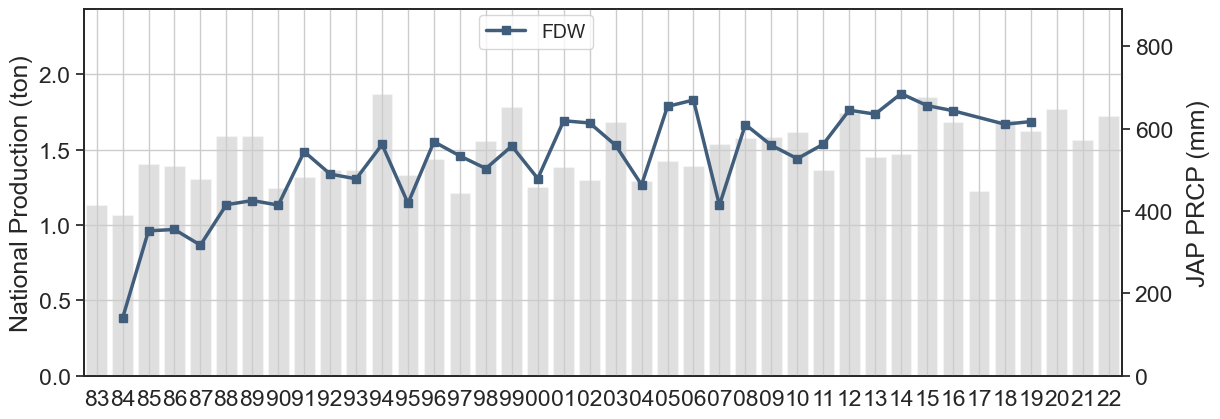

In [3]:
# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 7]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'JAP PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual (Main-season) Production - Maize

Correlation:
           FDW       FAO      PRCP
FDW   1.000000  0.998577  0.516686
FAO   0.998577  1.000000  0.524706
PRCP  0.516686  0.524706  1.000000


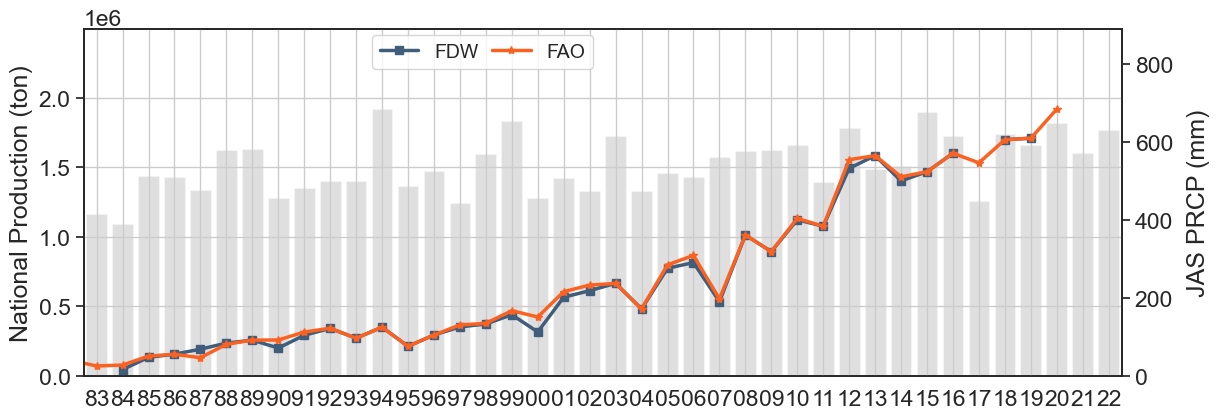

In [4]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize'])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 7]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'JAS PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #

### Annual (Main-season) Production - Sorghum

Correlation:
           FDW       FAO      PRCP
FDW   1.000000  0.918511  0.544052
FAO   0.918511  1.000000  0.494460
PRCP  0.544052  0.494460  1.000000


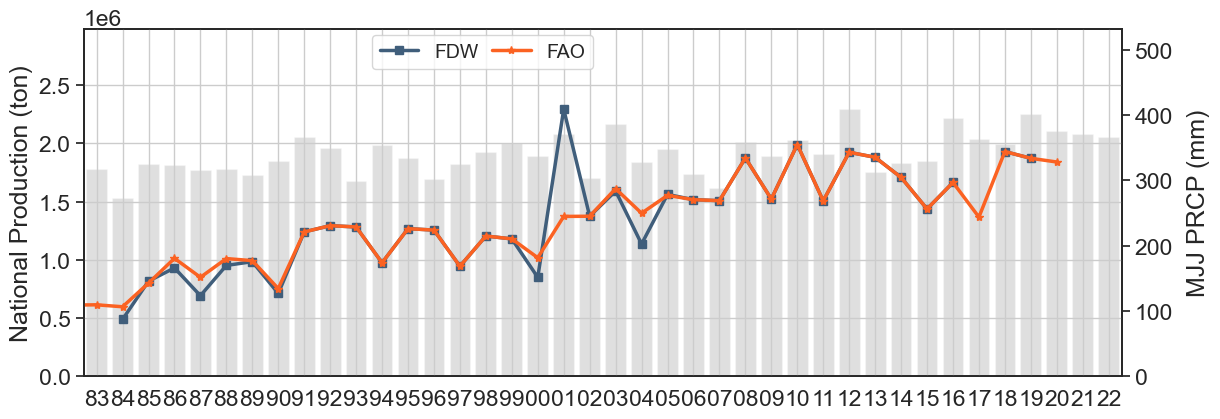

In [5]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'BF', 'Burkina Faso'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# Deyr-season
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Sorghum'])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == 'Burkina Faso') &
    (df['cpc2_name'] == 'Sorghum') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 5]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'MJJ PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1983,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'], alpha=1)
marker = ['s','*']
for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_ylim([0, data.max().max()*1.3])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #